In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
from sklearn import preprocessing
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio
import scipy as scp
import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper import plot_dna_logo, plot_importance_scores

import pandas as pd

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:

#optimus 5-prime functions 
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2


#Train data
e_train = pd.read_csv("bottom5KIFuAUGTop5KIFuAUG.csv")
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

seq_e_train = one_hot_encode(e_train,seq_len=50)
x_train = seq_e_train
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
y_train = np.array(e_train['scaled_rl'].values)
y_train = np.reshape(y_train, (y_train.shape[0],1))

#Test data
e_test = pd.DataFrame({
    'utr' : [
        "CAATGTGGACTTCTTTTAAACCTTTCTAATGCCCATAACCCAGCCTCAGA", #rs1408395879, loss_of_two_if_uorf, ref
        "CAGTGTGGACTTCTTTTAAACCTTTCTAATGCCCATAACCCAGCCTCAGA", #rs1408395879, loss_of_two_if_uorf, var
        "CGCGCCTCGGGATGCCCAGCTGATCAAGGAGCTGGGGCTGCGGCTGCTCT", #rs138958351, gain_of_one_oof_uaug, ref
        "CGCGCCTCGGGATGCCCAGATGATCAAGGAGCTGGGGCTGCGGCTGCTCT", #rs138958351, gain_of_one_oof_uaug, var
        "CCGGGTGGACACTGTTAGTGTAGTCATTGTCCCTATGGAGAAACTGAGGC", #rs886054324, gain_of_two_if_uorf, ref
        "CCGGGTGGACACTGTTAATGTAGTCATTGTCCCTATGGAGAAACTGAGGC", #rs886054324, gain_of_two_if_uorf, var
        "CCGGGTGGACACTGTTAGTGTAGTCATTGTCCCTACGGAGAAACTGAGGC", #rs886054324, gain_of_two_if_uorf, test ref no oof uaug
        "CCGGGTGGACACTGTTAATGTAGTCATTGTCCCTACGGAGAAACTGAGGC", #rs886054324, gain_of_two_if_uorf, test var no oof uaug
        "GAGAAGCGGCGATAATCTGTTTGAGGATGTAGGCACTGGTGTGAAGGAAC", #rs201336268, loss_of_two_if_uorf, ref
        "GAGAAGCGGCGATAATCTGTTTGAGGATATAGGCACTGGTGTGAAGGAAC", #rs201336268, loss_of_two_if_uorf, var
        "GAGAAGCGGCGATAATCTGTTTGAGGATGTAGGCACTGGTGTGCAGGAAC", #rs201336268, loss_of_two_if_uorf, test ref only left stop
        "GAGAAGCGGCGATAATCTGTTTGAGGATATAGGCACTGGTGTGCAGGAAC", #rs201336268, loss_of_two_if_uorf, test var only left stop
        "GAGAAGCGGCGATAATCTGTTTGAGGATGCAGGCACTGGTGTGAAGGAAC", #rs201336268, loss_of_two_if_uorf, test ref only right stop
        "GAGAAGCGGCGATAATCTGTTTGAGGATACAGGCACTGGTGTGAAGGAAC", #rs201336268, loss_of_two_if_uorf, test var only right stop
        "TAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTGGGCC", #rs779013762, gain_of_one_if_uorf, ref
        "TAAGAGCCGAGAGAGACATGAGGTGTCTCTGAAGCCCGGTCGCCTGAGCC", #rs779013762, gain_of_one_if_uorf, var
        "GACGATGCTGGAGAAGCTCTCGGACACCTACACCTGCTTCTCCACGGAAA", #rs200004304, gain_of_one_oof_uaug, ref
        "GATGATGCTGGAGAAGCTCTCGGACACCTACACCTGCTTCTCCACGGAAA", #rs200004304, gain_of_one_oof_uaug, var
        "CGGTTTAGGGCTTGGAAGATGAAAAGGAGGCCTCTGAGAATGAAACAGAC", #rs199566869, loss_of_one_oof_uaug, ref
        "CGGTTTAGGGCTTGGAAGATGAAAAGGAGGCCTCTGAGAGTGAAACAGAC", #rs199566869, loss_of_one_oof_uaug, var
        "CTGATGCTGAATATAAAAAACTTCATAGTTATGGAAGAGACCAGAAAGGA", #rs886062507, loss_of_one_oof_uaug, ref
        "CTGGTGCTGAATATAAAAAACTTCATAGTTATGGAAGAGACCAGAAAGGA", #rs886062507, loss_of_one_oof_uaug, var
        "CCACGGCTTAGCAAAGAATCCCAGACCCCGCCCGGGAAGGCAGCCGCACC", #rs201907247, gain_of_one_if_uorf, ref
        "CCATGGCTTAGCAAAGAATCCCAGACCCCGCCCGGGAAGGCAGCCGCACC", #rs201907247, gain_of_one_if_uorf, var
    ]
})
seq_e_test = one_hot_encode(e_test, seq_len=50)
x_test = seq_e_test
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))

y_test = np.zeros((x_test.shape[0],1))

var_ids = [
    "rs1408395879",
    "rs138958351",
    "rs886054324",
    "rs886054324_no_oof_uaug",
    "rs201336268",
    "rs201336268_left_stop",
    "rs201336268_right_stop",
    "rs779013762",
    "rs200004304",
    "rs199566869",
    "rs886062507",
    "rs201907247",
]

consequences = [
    "loss_of_two_if_uorf",
    "gain_of_one_oof_uaug",
    "gain_of_two_if_uorf",
    "gain_of_two_if_uorf",
    "loss_of_two_if_uorf",
    "loss_of_two_if_uorf",
    "loss_of_two_if_uorf",
    "gain_of_one_if_uorf",
    "gain_of_one_oof_uaug",
    "loss_of_one_oof_uaug",
    "loss_of_one_oof_uaug",
    "gain_of_one_if_uorf",
]

def _drop_seq_to_mask(s) :
    return np.reshape(
        np.array([0. if s[i] == 'X' else 1. for i in range(len(s))]),
        (1, 1, len(s), 1)
    )

drop_test = [
   _drop_seq_to_mask("NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN") for i in range(x_test.shape[0])
]

drop_test = np.concatenate(drop_test, axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))
print("drop_test.shape = " + str(drop_test.shape))


x_train.shape = (15008, 1, 50, 4)
x_test.shape = (24, 1, 50, 4)
y_train.shape = (15008, 1)
y_test.shape = (24, 1)
drop_test.shape = (24, 1, 50, 1)


In [3]:
#Define sequence template

sequence_template = "N" * 50
sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


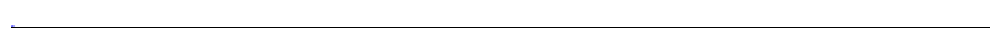

In [4]:
#Visualize background sequence distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [5]:
#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy

x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.032049298346210106


In [6]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.9679329305814974


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [8]:
#Load pre-trained model

save_dir = 'saved_models'

pretrained_model_name = 'autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_5_4_32_3_00_00_to_015_n_epochs_50_target_bits_0125_example_if_uorf_seqs_drop_multi_scale_weight_1'

def mask_dropout_multi_scale(mask, drop_scales=[1, 2, 4, 7], min_drop_rate=0.0, max_drop_rate=0.5) :
    
    rates = K.random_uniform(shape=(K.shape(mask)[0], 1, 1, 1), minval=min_drop_rate, maxval=max_drop_rate)
    
    scale_logits = K.random_uniform(shape=(K.shape(mask)[0], len(drop_scales), 1, 1, 1), minval=-5., maxval=5.)
    scale_probs = K.softmax(scale_logits, axis=1)
    
    ret_mask = mask
    for drop_scale_ix, drop_scale in enumerate(drop_scales) :
        ret_mask = mask_dropout(ret_mask, rates * scale_probs[:, drop_scale_ix, ...], drop_scale=drop_scale)
    
    return K.switch(K.learning_phase(), ret_mask, mask)

def mask_dropout(mask, drop_rates, drop_scale=1) :
    
    random_tensor_downsampled = K.random_uniform(shape=(
        K.shape(mask)[0],
        1,
        K.cast(K.shape(mask)[2] / drop_scale, dtype=tf.int32),
        K.shape(mask)[3]
    ), minval=0.0, maxval=1.0)
    
    keep_mask_downsampled = random_tensor_downsampled >= drop_rates
    
    keep_mask = K.repeat_elements(keep_mask_downsampled, rep=drop_scale, axis=2)
    
    ret_mask = mask * K.cast(keep_mask, dtype=tf.float32)
    
    return ret_mask

model_path = os.path.join(save_dir, pretrained_model_name + '.h5')
pretrained_model = load_model(model_path, custom_objects={
    'mask_dropout_multi_scale' : mask_dropout_multi_scale,
    'gumbel_softmax' : gumbel_softmax
})

print('Loaded scrambler model %s ' % (model_path))

#Generate pre-trained importance scores

batch_size = 32

s_test = np.zeros((x_test.shape[0], 1))
all_ones_mask = np.ones((x_test.shape[0], 1, x_test.shape[2], 1))

#Pad data
n_pad = batch_size - x_test.shape[0] % batch_size

x_test_padded = np.concatenate([x_test, np.zeros((n_pad, x_test.shape[1], x_test.shape[2], x_test.shape[3]))], axis=0)
s_test_padded = np.concatenate([s_test, np.zeros((n_pad, s_test.shape[1]))], axis=0)
all_ones_mask_padded = np.concatenate([all_ones_mask, np.zeros((n_pad, all_ones_mask.shape[1], all_ones_mask.shape[2], all_ones_mask.shape[3]))], axis=0)

_, _, _, pretrained_scores_test = pretrained_model.predict(x=[x_test_padded, all_ones_mask_padded, s_test_padded])

pretrained_scores_test = pretrained_scores_test[:-n_pad, ...]



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Loaded scrambler model saved_models/autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_resnet_5_4_32_3_00_00_to_015_n_epochs_50_target_bits_0125_example_if_uorf_seqs_drop_multi_scale_weight_1.h5 


In [9]:
#aparent_l_test, aparent_d_test#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [10]:
#Scrambler network definition

from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    def __init__(self, axes=(1, 2), trainable=True, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.axes = axes
        self.trainable = trainable
    def build(self, input_shape):
        self.beta  = self.add_weight(name='beta',shape=(input_shape[-1],),
                                     initializer='zeros',trainable=self.trainable)
        self.gamma = self.add_weight(name='gamma',shape=(input_shape[-1],),
                                     initializer='ones',trainable=self.trainable)
    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, self.axes, keep_dims=True)
        return tf.nn.batch_normalization(inputs, mean, variance, self.beta, self.gamma, 1e-6)

def load_scrambler_network(seq_length, norm_mode='conv', max_score_clip=5.) :

    #Discriminator network definition
    
    seed_input = Lambda(lambda x: K.zeros((1, 1), dtype=tf.int32))
    
    mask_dense = Embedding(1, seq_length, embeddings_initializer='glorot_normal', name='scrambler_mask_dense')
    
    mask_reshape = Reshape((1, seq_length, 1))
    
    mask_conv, mask_norm = None, None
    if norm_mode is not None and norm_mode == 'conv' :
        mask_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_mask_conv')
    elif norm_mode is not None and norm_mode == 'norm' :
        mask_norm = InstanceNormalization(name='scrambler_mask_norm')
        #mask_norm = BatchNormalization(axis=-1, name='scrambler_mask_norm')
    
    mask_act = Activation('softplus')
    
    onehot_to_logits = Lambda(lambda x: 2. * x - 1., name='scrambler_onehot_to_logits')
    
    scale_logits = Lambda(lambda x: x[1] * K.tile(x[0], (1, 1, 1, 4)), name='scrambler_logit_scale')
    
    clip_scores = Lambda(lambda x, max_score_clip=max_score_clip: K.relu(K.clip(x[1], 0., max_score_clip) - x[0]), name='scrambler_clip_scores')
    
    drop_multiply = Lambda(lambda x: x[0] * x[1], name='scrambler_drop_multiply')
    
    def _scrambler_func(sequence_input, drop_input, pretrained_scores) :

        mask_in = mask_reshape(mask_dense(seed_input(sequence_input)))
        
        #Final conv out
        if norm_mode is not None and norm_mode == 'conv' : 
            mask_out = mask_conv(mask_in)
        elif norm_mode is not None and norm_mode == 'norm' :
            mask_out = mask_norm(mask_in)
            #mask_out = mask_norm(mask_in, training=True)
        else :
            mask_out = mask_in
        
        mask_act_out = mask_act(mask_out)
        
        scores_out = drop_multiply([clip_scores([mask_act_out, pretrained_scores]), drop_input])
        
        #Scale inputs by importance scores
        scaled_inputs = scale_logits([scores_out, onehot_to_logits(sequence_input)])
        
        return scaled_inputs, scores_out

    return _scrambler_func


In [11]:
#Keras loss functions

def get_margin_entropy_ame_masked(pwm_start, pwm_end, pwm_background, max_bits=1.0) :
    
    def _margin_entropy_ame_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        margin_conservation = K.switch(mean_conservation > K.constant(max_bits, shape=(1,)), mean_conservation - K.constant(max_bits, shape=(1,)), K.zeros_like(mean_conservation))
    
        return margin_conservation
    
    return _margin_entropy_ame_masked

def get_target_entropy_sme_masked(pwm_start, pwm_end, pwm_background, target_bits=1.0) :
    
    def _target_entropy_sme_masked(pwm, pwm_mask) :
        conservation = pwm[:, 0, pwm_start:pwm_end, :] * K.log(K.clip(pwm[:, 0, pwm_start:pwm_end, :], K.epsilon(), 1. - K.epsilon()) / K.constant(pwm_background[pwm_start:pwm_end, :])) / K.log(2.0)
        conservation = K.sum(conservation, axis=-1)
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_conservation = K.sum(conservation * mask, axis=-1) / n_unmasked

        return (mean_conservation - target_bits)**2
    
    return _target_entropy_sme_masked

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred

def get_mse(loss_coeff=1.) :
    #returns mse function for optimus 
    def _mse(y_true, y_pred):
        return K.mean((y_true - y_pred)**2, axis=-1)
    return _mse


In [12]:
#Initialize Encoder and Decoder networks
batch_size = 1
seq_length = 50
n_samples = 32
#sample_mode = 'st'
sample_mode = 'gumbel'

norm_mode = 'norm'
max_score_clip = 4.

#Load scrambler
scrambler = load_scrambler_network(seq_length, norm_mode=norm_mode, max_score_clip=max_score_clip)

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [13]:
#Load Predictor
predictor_path = 'optimusRetrainedMain.hdf5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [14]:
#Build scrambler model
scrambler_class = Input(shape=(1,), name='scrambler_class')
scrambler_input = Input(shape=(1, seq_length, 4), name='scrambler_input')
scrambler_drop = Input(shape=(1, seq_length, 1), name='scrambler_drop')
scrambler_pretrained_scores = Input(shape=(1, seq_length, 1), name='scrambler_pretrained_scores')

scrambler_logits, importance_scores = scrambler(scrambler_input, scrambler_drop, scrambler_pretrained_scores)

pwm_logits, pwm, sampled_pwm, _, _ = sampler(scrambler_class, scrambler_logits)

scrambler_model = Model([scrambler_input, scrambler_drop, scrambler_pretrained_scores, scrambler_class], [pwm_logits, pwm, sampled_pwm, importance_scores])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [15]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class = Input(shape=(1,), name='ae_scrambler_class')
ae_scrambler_input = Input(shape=(1, seq_length, 4), name='ae_scrambler_input')
ae_scrambler_drop = Input(shape=(1, seq_length, 1), name='ae_scrambler_drop')
ae_scrambler_pretrained_scores = Input(shape=(1, seq_length, 1), name='ae_scrambler_pretrained_scores')

#Run encoder and decoder
_, scrambled_pwm, scrambled_sample, pwm_mask, _ = sampler(ae_scrambler_class, scrambler(ae_scrambler_input, ae_scrambler_drop, ae_scrambler_pretrained_scores)[0])

#Define layer to deflate sample axis
deflate_scrambled_sample = Lambda(lambda x: K.reshape(x, (batch_size * n_samples, 1, seq_length, 4)), name='deflate_scrambled_sample')

#Deflate sample axis
scrambled_sample_deflated = deflate_scrambled_sample(scrambled_sample)


In [16]:

def _make_prediction(inputs, predictor=predictor) :
    pred_seq_in = inputs
     
    pred_seq_in_perm = tf.squeeze(pred_seq_in, 1)
    
    outputs = predictor(pred_seq_in_perm)
    
    return outputs

def _make_prediction_scrambled(inputs, predictor=predictor, n_samples=n_samples) :
    pred_seq_in = inputs
     
    pred_seq_in_perm = tf.squeeze(pred_seq_in, 1)
    
    outputs = predictor(pred_seq_in_perm)
    
    return outputs

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled = Lambda(_make_prediction, name='make_prediction_non_scrambled')(ae_scrambler_input)

#Make prediction on scrambled sequence samples
y_pred_scrambled_deflated = Lambda(_make_prediction_scrambled, name='make_prediction_scrambled')(scrambled_sample_deflated)


In [17]:
#Define layer to inflate sample axis
inflate_scrambled_prediction = Lambda(lambda x: K.reshape(x, (batch_size, n_samples)), name='inflate_scrambled_prediction')

#Inflate sample axis
y_pred_scrambled = inflate_scrambled_prediction(y_pred_scrambled_deflated)

#Cost function parameters
pwm_start = 0
pwm_end = 50
max_bits = 0.0

#OPTIMUS: switched to MSE 
mse_loss_func = get_mse()

#Conservation cost
conservation_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=1.8)

#Entropy cost
#entropy_loss_func = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, target_bits=target_bits)
entropy_loss_func = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, pwm_background=x_mean, max_bits=max_bits)

#Define annealing coefficient
anneal_coeff = K.variable(0.0)

#Execute NLL cost
mse_loss = Lambda(lambda x: mse_loss_func(K.tile(x[0], (1, K.shape(x[1])[1])), x[1]), name='mse')([y_pred_non_scrambled, y_pred_scrambled])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x[0], x[1]), name='conservation')([scrambled_pwm, pwm_mask])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x[0], x[1]), name='entropy')([scrambled_pwm, pwm_mask])

loss_model = Model(
    [ae_scrambler_class, ae_scrambler_input, ae_scrambler_drop, ae_scrambler_pretrained_scores],
    [mse_loss, conservation_loss, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(loss_model, [sequence_template], [x_mean_logits])


In [18]:
#Training configuration

#Define experiment suffix (optional)
experiment_suffix = "_example_if_uorf_seqs_per_example_finetuning"

dataset_name = "egfp_unmod_1"

model_name = "autoscrambler_dataset_" + dataset_name + "_sample_mode_" + sample_mode + "_n_samples_" + str(n_samples) + "_max_bits_" + str(max_bits).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_egfp_unmod_1_sample_mode_gumbel_n_samples_32_max_bits_00_example_if_uorf_seqs_per_example_finetuning


In [19]:
#(Re-)Initialize scrambler mask

def reset_generator(scrambler_model, verbose=False) :
    session = K.get_session()
    for layer in scrambler_model.layers :
        if 'scrambler' in layer.name :
            for v in layer.__dict__:
                v_arg = getattr(layer, v)
                if hasattr(v_arg,'initializer'):
                    initializer_method = getattr(v_arg, 'initializer')
                    initializer_method.run(session=session)
                    if verbose :
                        print('reinitializing layer {}.{}'.format(layer.name, v))

#(Re-)Initialize Optimizer

def reset_optimizer(opt, verbose=False) :
    session = K.get_session()
    for v in opt.__dict__:
        v_arg = getattr(opt, v)
        if hasattr(v_arg,'initializer'):
            initializer_method = getattr(v_arg, 'initializer')
            initializer_method.run(session=session)
            if verbose :
                print('reinitializing optimizer parameter {}'.format(v))


In [29]:
#Execute training procedure

class LossHistory(keras.callbacks.Callback) :
    
    def on_train_begin(self, logs={}):
        self.nll_losses = []
        self.entropy_losses = []
        self.conservation_losses = []

    def on_batch_end(self, batch, logs={}) :
        self.nll_losses.append(logs.get('mse_loss'))
        self.entropy_losses.append(logs.get('entropy_loss'))
        self.conservation_losses.append(logs.get('conservation_loss'))

#Define number of training epochs
n_iters = 300

opt = keras.optimizers.Adam(lr=0.01, beta_1=0.5, beta_2=0.9)

loss_model.compile(
    optimizer=opt,
    loss={
        'mse' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=5.0)
    }
)

#Reset mask
reset_generator(scrambler_model, verbose=False)
reset_generator(loss_model, verbose=False)
reset_optimizer(opt, verbose=False)

s_test = np.zeros((1, 1))

pwm_test = []
sample_test = []
importance_scores_test = []
train_histories = []

for data_ix in range(x_test.shape[0]) :
    
    if data_ix % 100 == 0 :
        print("Optimizing example " + str(data_ix) + "...")
    
    train_history = LossHistory()
    
    # train the autoencoder
    _ = loss_model.fit(
        [s_test, x_test[data_ix:data_ix+1], drop_test[data_ix:data_ix+1], pretrained_scores_test[data_ix:data_ix+1]],
        [s_test, s_test, s_test],
        epochs=1,
        steps_per_epoch=n_iters,
        callbacks=[train_history]
    )
    
    _, temp_pwm, temp_sample, temp_importance_scores = scrambler_model.predict_on_batch(x=[x_test[data_ix:data_ix+1], drop_test[data_ix:data_ix+1], pretrained_scores_test[data_ix:data_ix+1], s_test])
    
    pwm_test.append(temp_pwm)
    sample_test.append(temp_sample)
    importance_scores_test.append(temp_importance_scores)
    train_histories.append(train_history)
    
    #Reset mask
    reset_generator(scrambler_model)
    reset_generator(loss_model)
    reset_optimizer(opt)

pwm_test = np.concatenate(pwm_test, axis=0)
sample_test = np.concatenate(sample_test, axis=0)
importance_scores_test = np.concatenate(importance_scores_test, axis=0)


Optimizing example 0...
Epoch 1/1
300/300 [==============================] - 5s 18ms/step - loss: 1.2479 - mse_loss: 0.4436 - conservation_loss: 0.0000e+00 - entropy_loss: 0.8042
Epoch 1/1
300/300 [==============================] - 3s 10ms/step - loss: 1.1057 - mse_loss: 0.5550 - conservation_loss: 0.0000e+00 - entropy_loss: 0.5507
Epoch 1/1
300/300 [==============================] - 3s 10ms/step - loss: 1.4785 - mse_loss: 0.3347 - conservation_loss: 0.0000e+00 - entropy_loss: 1.1438
Epoch 1/1
300/300 [==============================] - 3s 10ms/step - loss: 0.9986 - mse_loss: 0.3766 - conservation_loss: 0.0000e+00 - entropy_loss: 0.6220
Epoch 1/1
300/300 [==============================] - 3s 10ms/step - loss: 0.9801 - mse_loss: 0.2420 - conservation_loss: 0.0000e+00 - entropy_loss: 0.7381
Epoch 1/1
300/300 [==============================] - 3s 10ms/step - loss: 1.8081 - mse_loss: 0.4882 - conservation_loss: 0.0000e+00 - entropy_loss: 1.3199
Epoch 1/1
300/300 [===========================

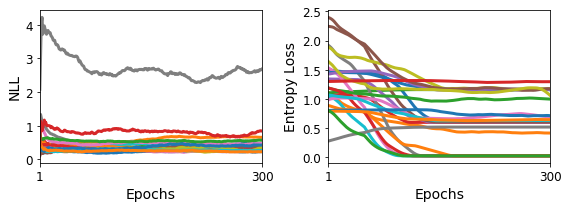

In [27]:

save_figs = True

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_histories[0].nll_losses)

nll_rolling_window = 50
entropy_rolling_window = 50

for k in range(len(train_histories)) :
    
    train_history = train_histories[k]

    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(train_history.nll_losses), window=nll_rolling_window), linewidth=3)

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("NLL", fontsize=14)
    plt.xlim(1, n_epochs_actual)
    plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.array(train_history.entropy_losses), window=entropy_rolling_window), linewidth=3)

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs_actual)
    plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
    plt.yticks(fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + '_losses.png', transparent=True, dpi=150)
    plt.savefig(model_name + '_losses.eps')

plt.show()


Variant 0: rs1408395879
Consequence: loss_of_two_if_uorf
- Ref -
 - Prediction (original) = -1.5
 - Predictions (scrambled) = [-2.1, -1.4, -1.3, -0.7, -0.8, -0.9, -1.6, -1.4, -0.6, -0.6]


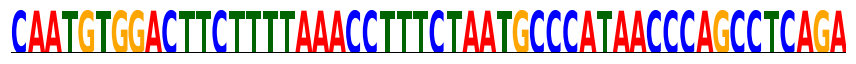

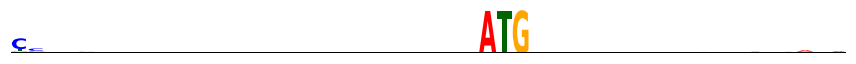

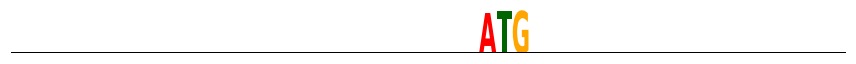

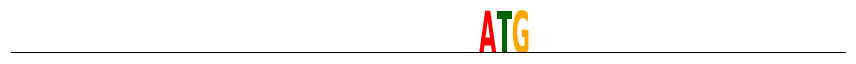

- Var -
 - Prediction (original) = -0.4
 - Predictions (scrambled) = [-0.1, 0.06, 0.68, 0.59, 0.48, -0.3, 0.06, 0.69, 0.79, -0.3]


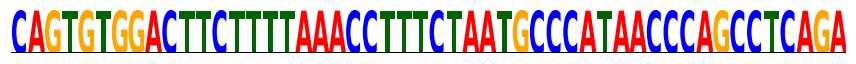

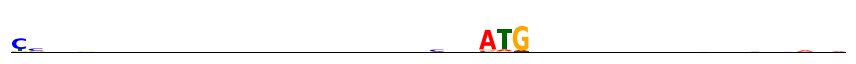

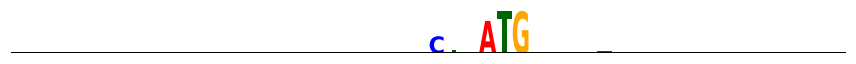

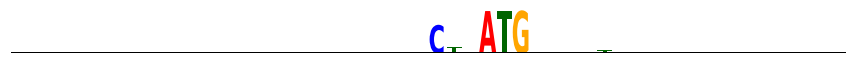

Variant 1: rs138958351
Consequence: gain_of_one_oof_uaug
- Ref -
 - Prediction (original) = -1.1
 - Predictions (scrambled) = [-0.7, -0.8, -0.8, -1.2, -0.5, -0.8, -1.1, 0.05, -1.0, -0.5]


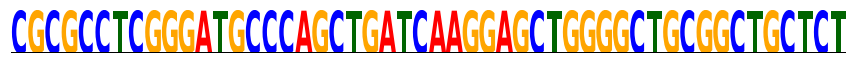

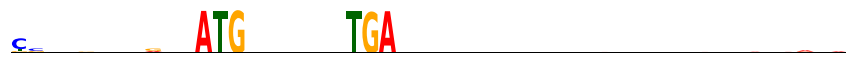

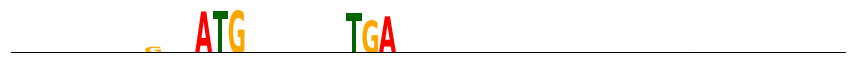

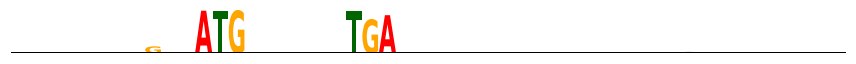

- Var -
 - Prediction (original) = -1.2
 - Predictions (scrambled) = [-1.4, -0.7, -1.4, -1.0, -1.0, -1.5, 0.11, -1.3, -1.1, -1.1]


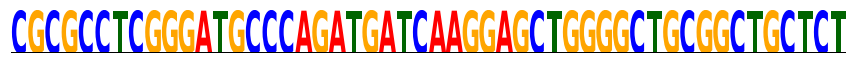

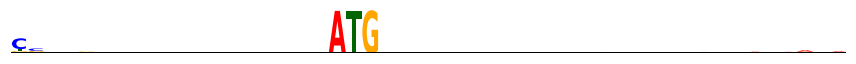

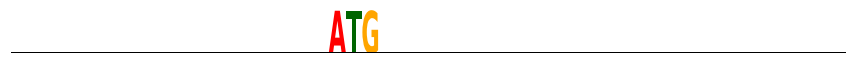

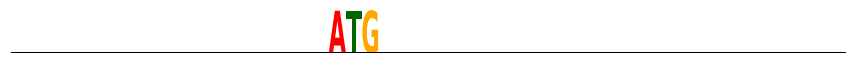

Variant 2: rs886054324
Consequence: gain_of_two_if_uorf
- Ref -
 - Prediction (original) = -1.1
 - Predictions (scrambled) = [-1.0, -0.9, -1.7, -0.9, -1.5, -1.9, -0.8, -0.9, -1.3, -0.6]


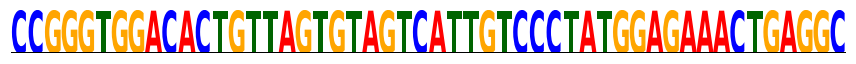

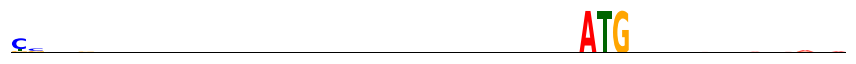

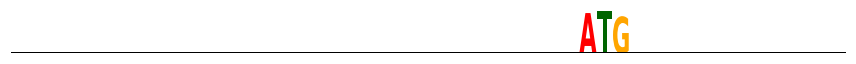

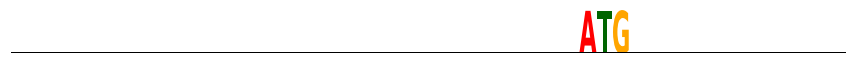

- Var -
 - Prediction (original) = -1.2
 - Predictions (scrambled) = [-1.3, -0.4, -1.1, -0.9, -0.6, -1.1, -1.5, -1.4, -1.5, -1.1]


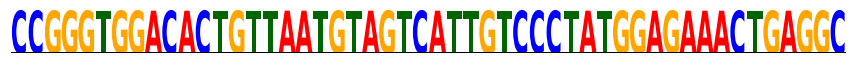

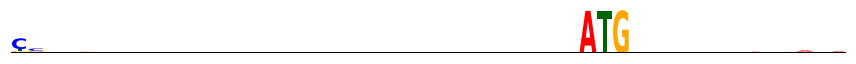

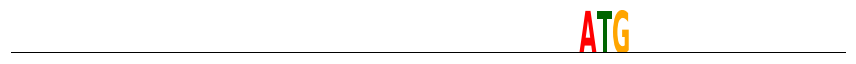

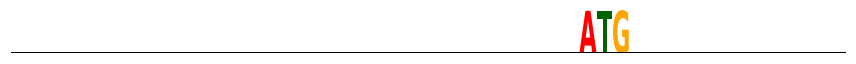

Variant 3: rs886054324_no_oof_uaug
Consequence: gain_of_two_if_uorf
- Ref -
 - Prediction (original) = 0.6
 - Predictions (scrambled) = [0.59, 0.14, 0.55, 0.53, 0.92, 0.77, 0.77, 0.83, 0.67, -1.5]


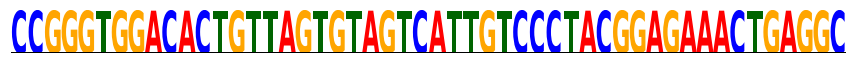

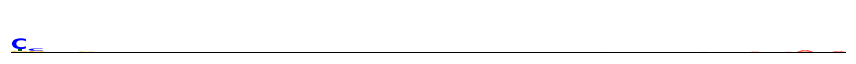

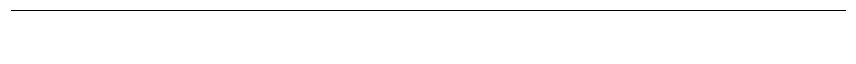

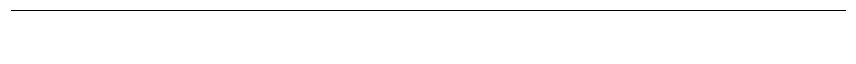

- Var -
 - Prediction (original) = 0.17
 - Predictions (scrambled) = [0.91, 0.86, 0.73, -0.1, 0.76, 0.81, 0.75, 0.26, 0.67, 0.91]


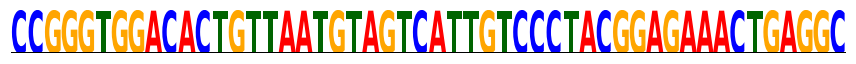

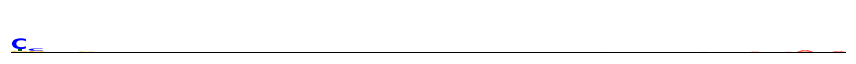

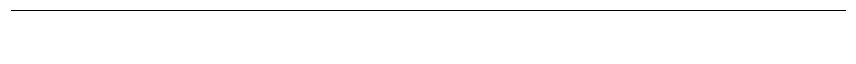

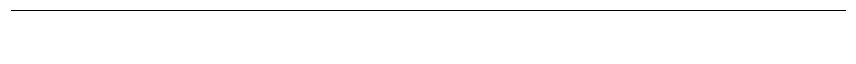

Variant 4: rs201336268
Consequence: loss_of_two_if_uorf
- Ref -
 - Prediction (original) = -1.3
 - Predictions (scrambled) = [-1.0, -1.4, -1.0, -1.3, -1.2, -0.8, -0.6, -1.5, -1.0, -1.2]


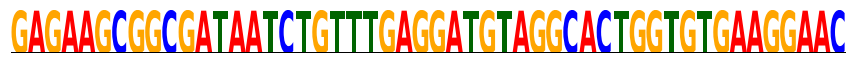

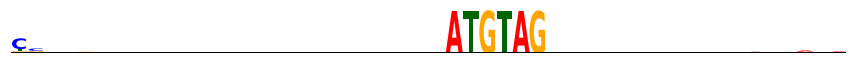

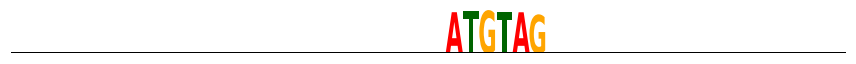

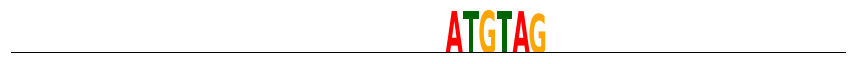

- Var -
 - Prediction (original) = 0.93
 - Predictions (scrambled) = [0.76, 0.78, 0.4, 0.8, 0.66, 0.66, 0.35, 0.84, -0.5, 0.71]


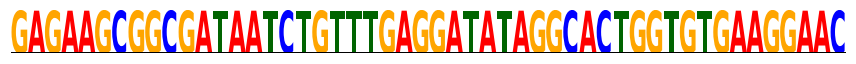

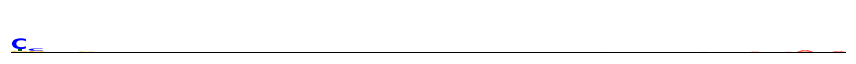

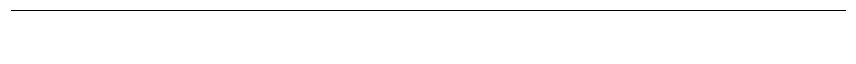

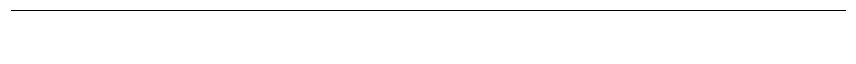

Variant 5: rs201336268_left_stop
Consequence: loss_of_two_if_uorf
- Ref -
 - Prediction (original) = -1.2
 - Predictions (scrambled) = [-1.3, -0.3, -0.7, -2.1, -1.2, -0.9, -1.0, -0.8, -1.0, -1.1]


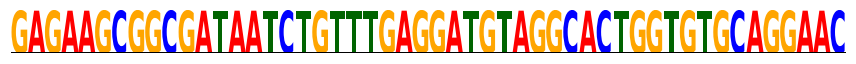

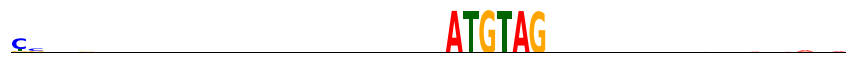

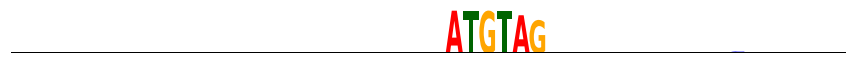

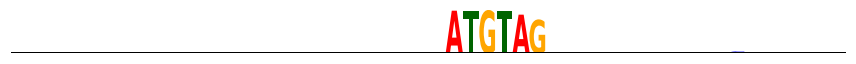

- Var -
 - Prediction (original) = 0.9
 - Predictions (scrambled) = [0.75, 0.82, 0.66, -0.1, 0.42, 0.52, 0.72, 0.9, 0.83, 0.61]


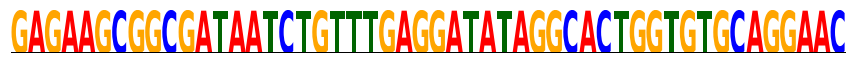

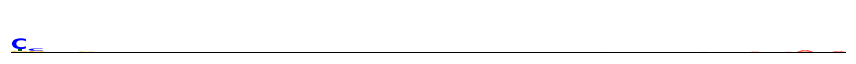

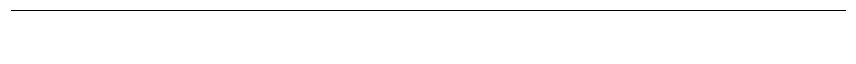

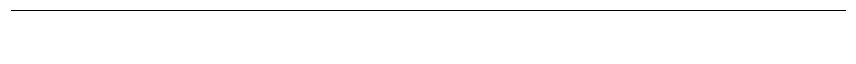

Variant 6: rs201336268_right_stop
Consequence: loss_of_two_if_uorf
- Ref -
 - Prediction (original) = -0.5
 - Predictions (scrambled) = [-0.3, -0.7, -0.7, -0.8, -0.8, -0.7, -0.8, -0.3, -0.6, -1.5]


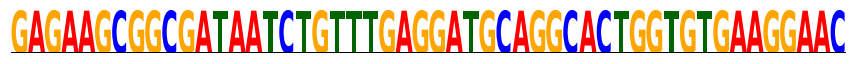

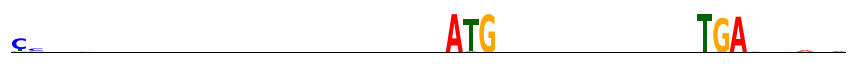

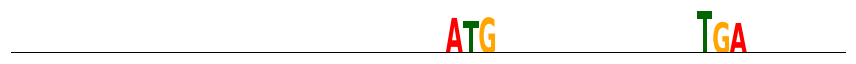

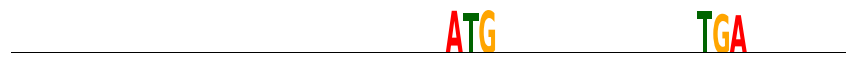

- Var -
 - Prediction (original) = 0.82
 - Predictions (scrambled) = [0.71, 0.57, 0.6, 0.77, 0.95, 0.66, 0.48, 0.88, 0.71, 0.16]


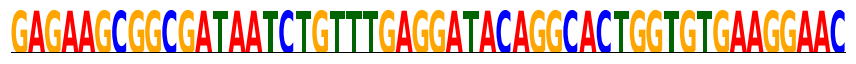

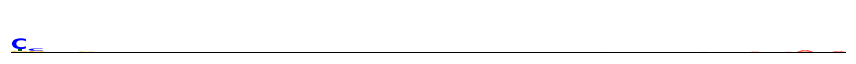

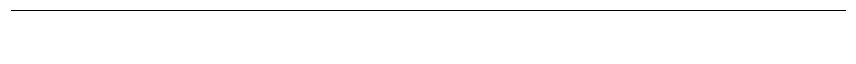

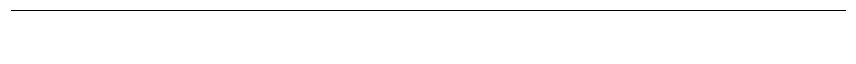

Variant 7: rs779013762
Consequence: gain_of_one_if_uorf
- Ref -
 - Prediction (original) = -0.8
 - Predictions (scrambled) = [-0.9, -0.5, -0.4, -0.4, 0.05, -0.9, -0.2, -0.7, -0.7, -0.8]


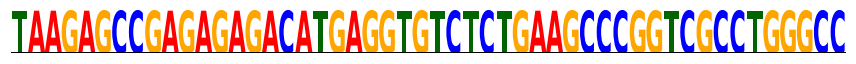

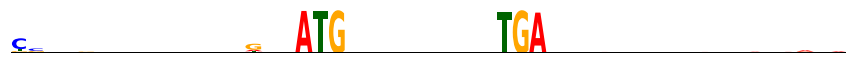

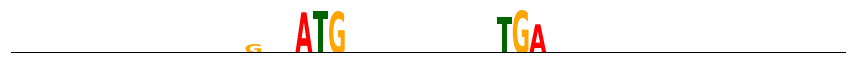

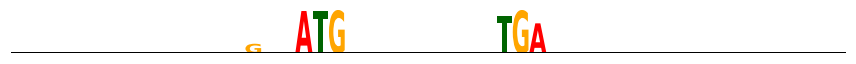

- Var -
 - Prediction (original) = -1.0
 - Predictions (scrambled) = [-0.0, -0.1, -0.6, -0.3, -0.6, -1.1, -1.3, -1.3, -0.7, -0.9]


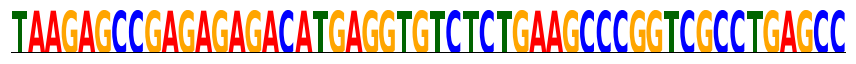

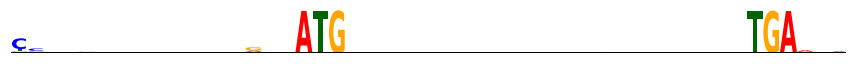

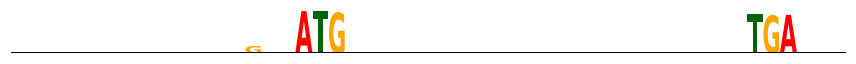

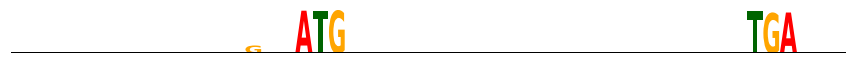

Variant 8: rs200004304
Consequence: gain_of_one_oof_uaug
- Ref -
 - Prediction (original) = -1.7
 - Predictions (scrambled) = [-1.7, -2.0, -2.0, -1.8, -1.9, -0.9, -1.2, -1.7, -1.1, -1.6]


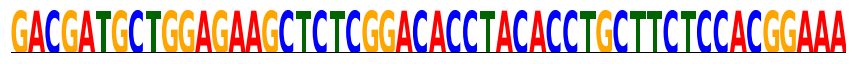

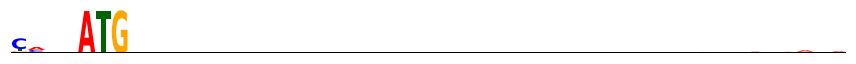

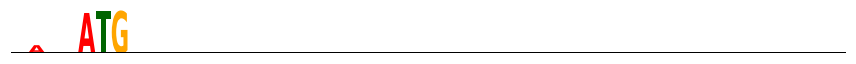

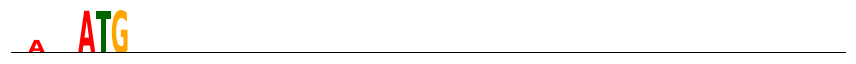

- Var -
 - Prediction (original) = -1.5
 - Predictions (scrambled) = [-1.5, 0.68, 0.74, -0.4, -0.1, 0.6, -0.7, 0.81, 0.84, -1.3]


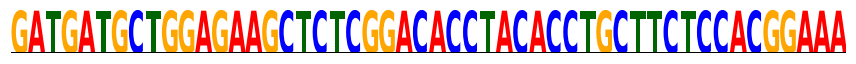

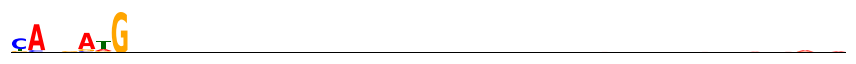

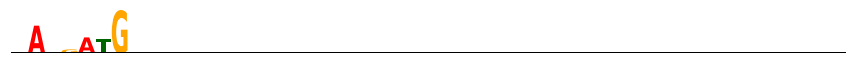

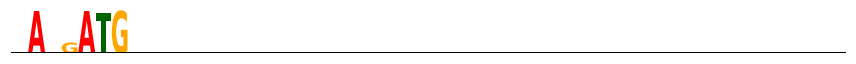

Variant 9: rs199566869
Consequence: loss_of_one_oof_uaug
- Ref -
 - Prediction (original) = -1.3
 - Predictions (scrambled) = [-1.1, -1.2, -0.5, -1.3, 0.01, -0.5, -0.7, -1.2, -1.0, 0.15]


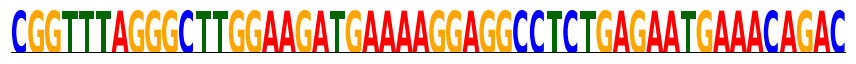

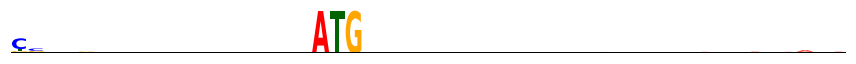

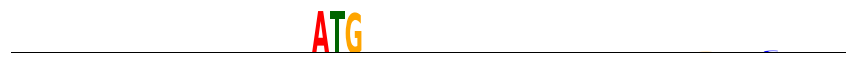

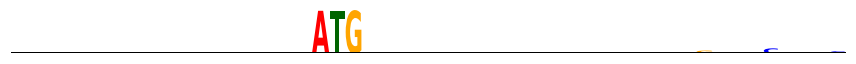

- Var -
 - Prediction (original) = -0.8
 - Predictions (scrambled) = [-1.1, -1.3, -0.6, -1.2, -0.7, -0.1, -1.0, -0.8, -1.0, -1.4]


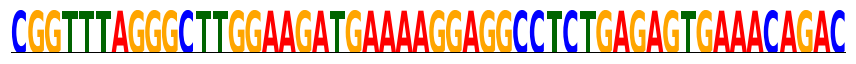

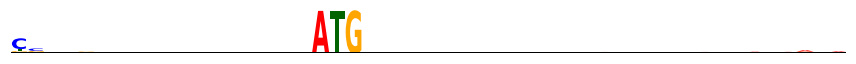

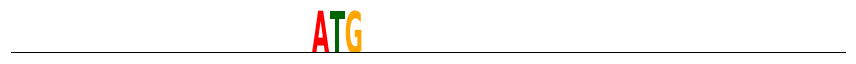

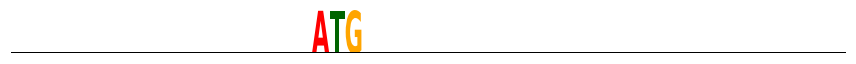

Variant 10: rs886062507
Consequence: loss_of_one_oof_uaug
- Ref -
 - Prediction (original) = -1.5
 - Predictions (scrambled) = [-1.3, -0.5, -0.9, -1.1, -0.8, -1.1, -0.7, -1.3, -0.1, -0.8]


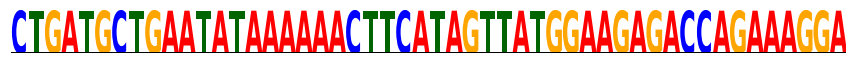

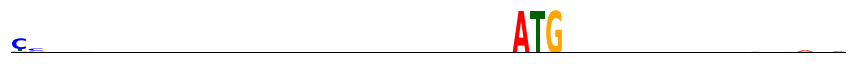

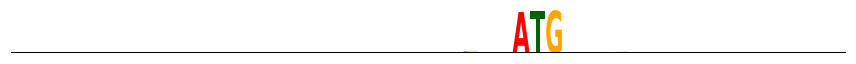

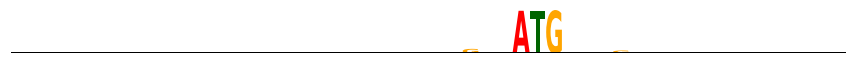

- Var -
 - Prediction (original) = -1.1
 - Predictions (scrambled) = [-0.4, -0.8, -1.0, -1.2, -0.8, -1.1, -0.8, -1.5, -0.1, -1.2]


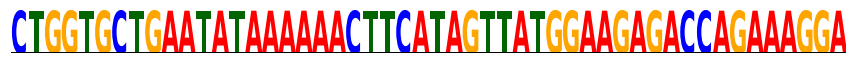

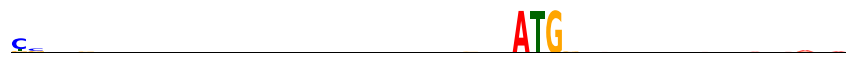

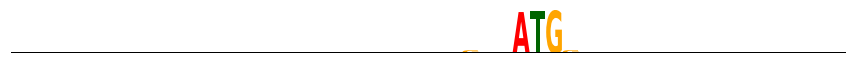

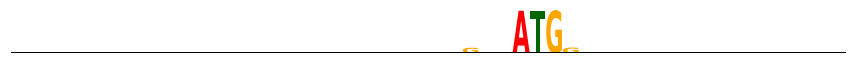

Variant 11: rs201907247
Consequence: gain_of_one_if_uorf
- Ref -
 - Prediction (original) = -0.0
 - Predictions (scrambled) = [0.79, 0.61, 0.62, 0.66, 0.74, 0.32, 0.75, 0.77, 0.76, 0.83]


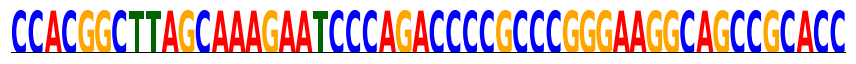

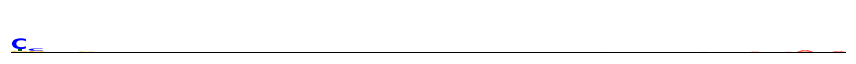

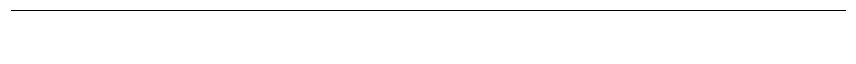

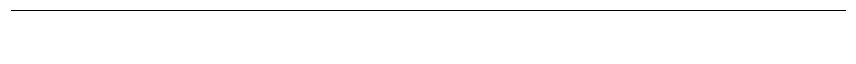

- Var -
 - Prediction (original) = -1.9
 - Predictions (scrambled) = [-0.9, -1.0, -1.2, -1.2, -1.2, -1.0, -1.3, -1.1, -1.4, -1.5]


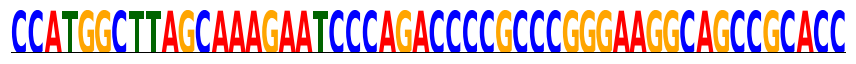

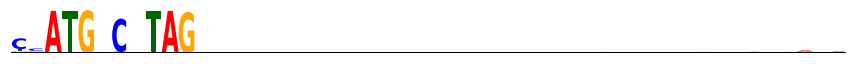

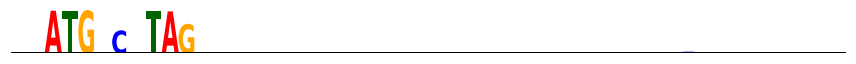

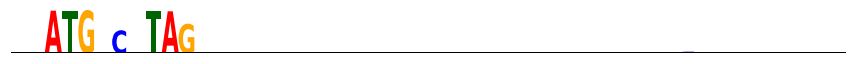

In [28]:
#Visualize a few reconstructed sequence patterns
from sequence_logo_helper import plot_dna_logo

encoder = isol.OneHotEncoder(50)

save_figs = True
fig_name = model_name[model_name.index("max_bits"):] + "_variant_examples"

for plot_i in range(0, x_test.shape[0]) :
    
    if plot_i % 2 == 0 :
        print("Variant " + str(plot_i // 2) + ": " + var_ids[plot_i // 2])
        print("Consequence: " + consequences[plot_i // 2])
        print("- Ref -")
    else :
        print("- Var -")
    
    justPred = np.expand_dims(np.expand_dims(x_test[plot_i, 0, :, :], axis=0), axis=-1)
    justPredReshape = np.reshape(justPred, (1,50,4))
    
    expanded = np.expand_dims(sample_test[plot_i, :, 0, :, :], axis=-1)
    expandedReshape = np.reshape(expanded, (n_samples, 50,4))
    
    y_test_hat_ref = predictor.predict(x=justPredReshape, batch_size=1)[0][0]
    y_test_hat = predictor.predict(x=[expandedReshape], batch_size=32)[:10, 0]
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    plot_dna_logo(x_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=50, save_figs=save_figs, fig_name=fig_name + "_" + str(plot_i) + "_orig_sequence")
    plot_dna_logo(pwm_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=50, save_figs=save_figs, fig_name=fig_name + "_" + str(plot_i) + "_scrambled_pwm")
    plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=50, save_figs=save_figs, fig_name=fig_name + "_" + str(plot_i) + "_scores")
    plot_importance_scores(importance_scores_test[plot_i, 0, :, :].T, encoder.decode(x_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=np.quantile(importance_scores_test[plot_i, 0, :, :], q=0.95), sequence_template=sequence_template, plot_start=0, plot_end=50, save_figs=save_figs, fig_name=fig_name + "_" + str(plot_i) + "_scores_qt_95")
